# Lending Club Data Loan Default Prediction

In [2]:
library(dplyr)

library(lubridate)
library(ggplot2)
library(dplyr)
library(stringr)
library(caret)
library(rpart)
#library(rattle)
library(ROSE)
library(ROCR)
library(MASS)
library(ipred)
library(plyr)
library(rpart.plot)
require(gridExtra) # also loads grid

library(data.table)
options(datatable.print.nrows = 500)
options(width = 110)
options(repr.plot.width=11, repr.plot.height=5)

In [3]:
# Set working path:
wkdir = "/Users/qiaolinchen/Documents/LendingClub/"
raw_data_path = paste0(wkdir, 'raw_data/')

## 1.Load data from CSV files

In [6]:
loans = read.csv( paste0(wkdir ,'loan_2016-2017.csv') )

In [7]:
dim(loans)

[1] 758390    124

In [8]:
drop_list = c('zip3d', 'id', 'url', 'zip_code' )

drop_from_model = c('issue_d', 'loan_status','out_prncp', 'out_prncp_inv',   'total_rec_prncp', 
                    'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                   'last_pymnt_d', 'last_pymnt_amnt', 'Loan_Status', 'fully_paid', 'year_issued' )

In [14]:
df = data.frame(loans)

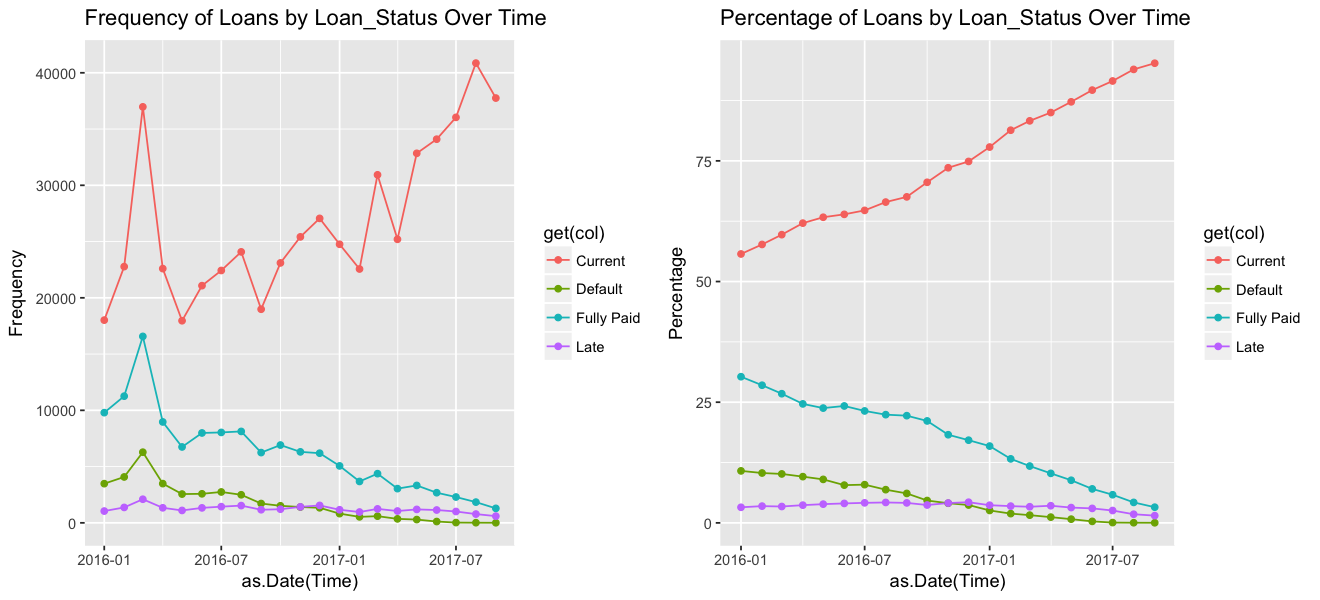

In [32]:
plot_over_time = function(df = df, col ='Loan_Status'){
    options(repr.plot.width=11, repr.plot.height=5)
    count = table( df$issue_d, df[,col]  )
    counts = melt( count ) 
    colnames(counts) = c('Time', col ,'Frequency')

    pct = melt( round( count/ apply( count,1,sum) *100 ,digits= 2) )
    colnames(pct) = c('Time', col ,'Percentage')

    p1 = ggplot(data= counts, aes(x= as.Date(Time), y= Frequency, group= get(col) , colour= get(col) )) +
        geom_line() + geom_point() +ggtitle(paste0('Frequency of Loans by ', col,' Over Time') )
    p2 = ggplot(data= pct, aes(x= as.Date(Time), y= Percentage, group= get(col) , colour= get(col) )) +
        geom_line() + geom_point() +ggtitle(paste0('Percentage of Loans by ', col,' Over Time') )
    grid.arrange(p1, p2, ncol=2)
}
plot_over_time(df=df,  col= 'Loan_Status')

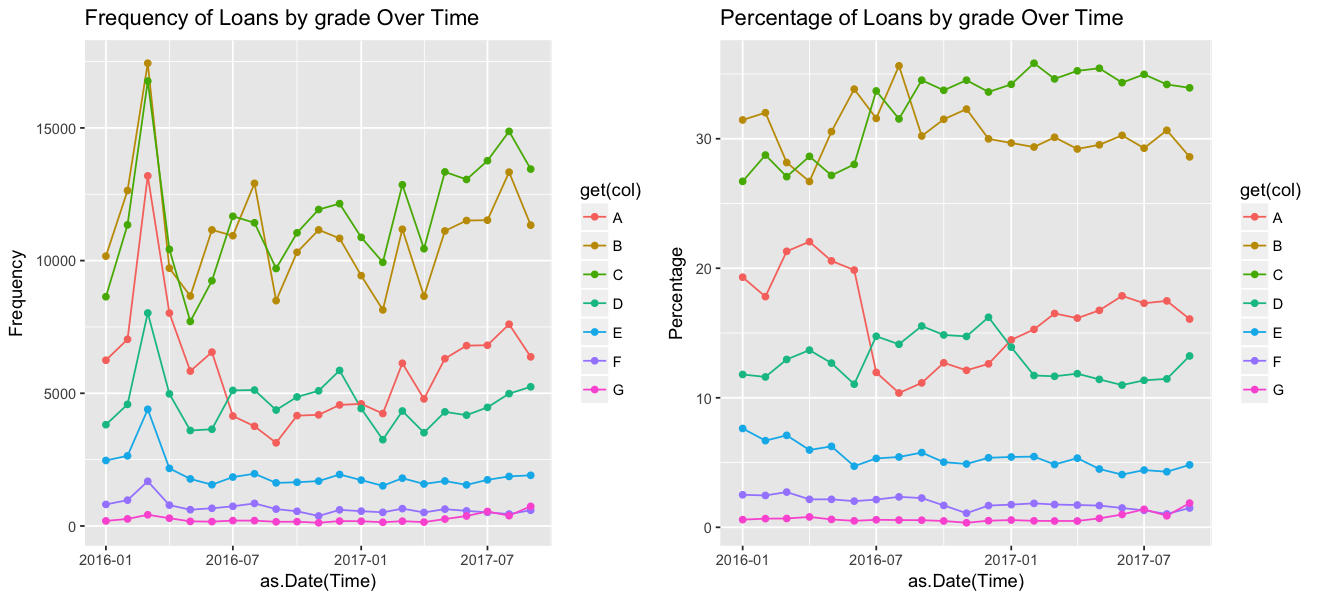

In [33]:
plot_over_time(df=df,  col= 'grade')